# 인물사진을 만들어보자

### -1 인물사진 모드란?

배경흐리는 기술을 아웃포커싱이라고 하나 실제로 외국에서 쓰는 단어는 shallow depth of field, shallow focus. 일본에서는 bokeh라고도 한다. 아이폰에서 인물사진모드를 생각하면 된다
mkdir -p ~/aiffel/human_segmentation/models  
mkdir -p ~/aiffel/human_segmentation/images

### -2 사진을 준비하자

우리가 shallow focus를 만드는 방식은 사진에서 semantic segmentation(이미지 시그멘테이션)으로 사람과 배경을 분리한 후에 배경을 blur처리하고 다시 합치는 방식  
    - aiffel/human_segmentation
        ├── models
            └── deeplab_model.tar.gz (미리 준비할 필요는 없습니다.)
        ├── images
            └── my_image.png   (사진 이름은 각자 파일명에 따라 다르게 사용하시면 됩니다)  
pip install opencv-python           

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2316, 3088, 3)


### -2 세그멘테이션으로 사람 분리하기  

이미지 세그멘테이션:이미지에서 픽셀단위로 관심객체를 추출하는 방법  
모든 픽셀에 라벨링하는데, 같은 라벨은 공통적인 특징을 가진다는 뜻.  
우리가 인식하는 것처럼 물리적인 의미단위로 인식하는 방식이 시멘틱 세그멘테이션  
시멘틱은 사람, 동물, 식물등으로만 분류하기에 사람끼리는 분류가 안되어 인스턴스 세그멘테이션을 쓴다.(사람마다 다르게 라벨링)  
인스턴스 세그멘테이션 데이터셋+라벨+클래스라벨->시멘틱세그멘테이션 학습가능  
물체의 경계를 나누는 알고리즘은 watershed segmentation.

### -3 시멘틱 세그멘테이션 다루기  

이미지 세그멘테이션에도 많은 모델이 있는데 그중에 DeepLab v3+를 사용. 

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))#resize
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)#opencv에 맞게 색깔변환
        img_input = resized_rgb
        return img_input
        
    def run(self, image): #실제로 세그멘테이션하는 곳
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
#학습된 가중치를 갖고 오기
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac19/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
#준비한 이미지를 네트워크에 넣기
#seg_map.max()는 넣은 사진에서 지정된 라벨들 중에서 가장 큰 값을 반환
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2316, 3088, 3) (384, 513, 3) 15


In [6]:
#구글에서 제공된 라벨들.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

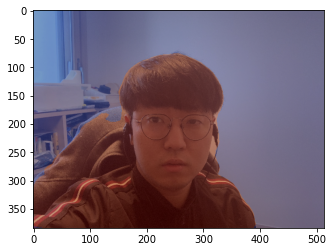

In [7]:
#사람만 검출, 마스크를 만들고 시각화
#사람을 뜻하는 15외에는 모두다 0으로 만듬
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### -4 세그멘테이션 결과를 다시 원래 크기로 복원.  

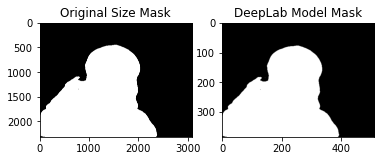

In [8]:
#아까 전처리과정중에 사이즈를 작게 했기에 출력을 위해서 다시 복원
#복원시에는 보간을 사용해야 하는데, 정확하게 하기 위해서 cv2.INTER_LINEAR를 사용.
#결과물인 img_mask_up은 threshold(임계값)을 기준으로 이하면 0, 이상이면 255로 만든다.
#grayscale이어서 결과물이 까맣게 나온다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### -5 배경 흐리게 만들기  

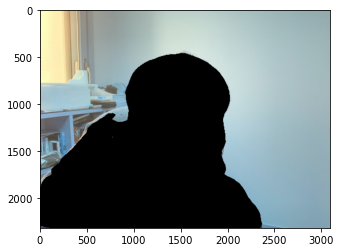

In [9]:
#세그멘테이션 마스크를 이용해 배겸만 추출
#bitwise_not을 쓰면 배경은 255, 사람은 0
#bitwise_and를 이용해 원래 이미지에 사람이 까만부분을 더한다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

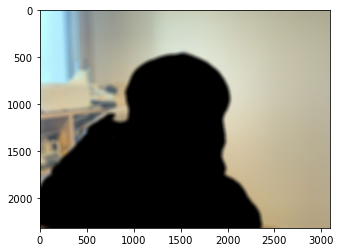

In [10]:
#배경만 나온 이미지를 블러처리
img_bg_blur = cv2.blur(img_bg, (50,50)) #뒤에 숫자가 클수록 블러처리가 많이됨
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### -6 흐린 배경과 원본 이미지 합성  

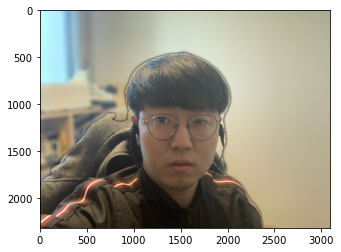

In [11]:
#마스크가 255인 부분만 원본이미지, 나머지 부분은 블러한 값 가저오기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(266, 400, 3)
(266, 400, 3) (341, 513, 3) 8


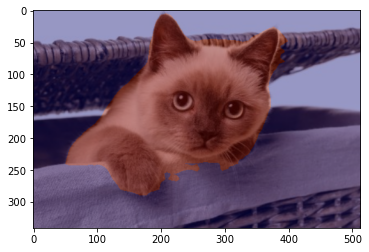

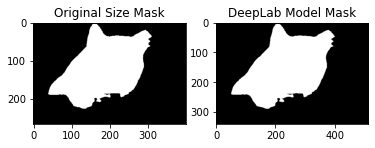

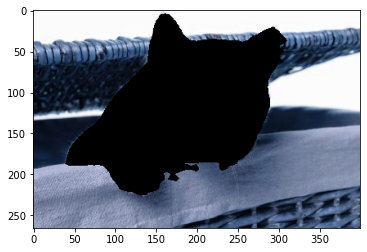

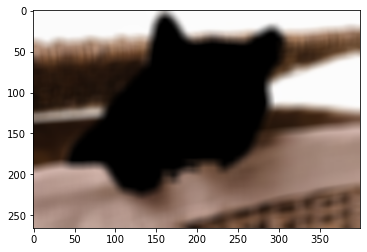

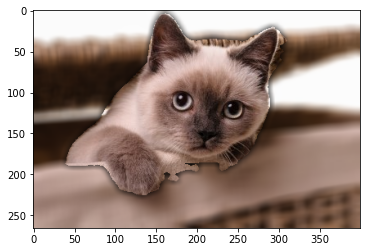

In [12]:
# 고양이 버전

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

#준비한 이미지를 네트워크에 넣기
#seg_map.max()는 넣은 사진에서 지정된 라벨들 중에서 가장 큰 값을 반환
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#고양이만 검출, 마스크를 만들고 시각화
#고양이을 뜻하는 15외에는 모두다 0으로 만듬
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#아까 전처리과정중에 사이즈를 작게 했기에 출력을 위해서 다시 복원
#복원시에는 보간을 사용해야 하는데, 정확하게 하기 위해서 cv2.INTER_LINEAR를 사용.
#결과물인 img_mask_up은 threshold(임계값)을 기준으로 이하면 0, 이상이면 255로 만든다.
#grayscale이어서 결과물이 까맣게 나온다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#세그멘테이션 마스크를 이용해 배겸만 추출
#bitwise_not을 쓰면 배경은 255, 고양이은 0
#bitwise_and를 이용해 원래 이미지에 사람이 까만부분을 더한다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()


#배경만 나온 이미지를 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13)) #뒤에 숫자가 클수록 블러처리가 많이 됨
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#마스크가 255인 부분만 원본이미지, 나머지 부분은 블러한 값 가저오기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


(2316, 3088, 3)
(2316, 3088, 3) (384, 513, 3) 15


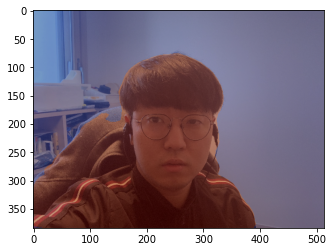

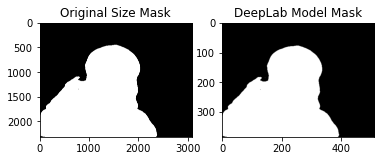

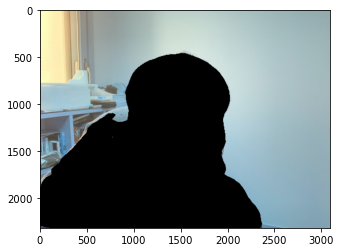

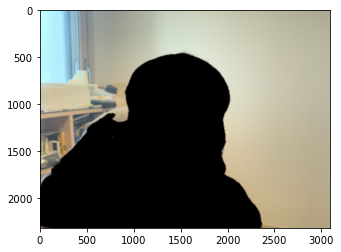

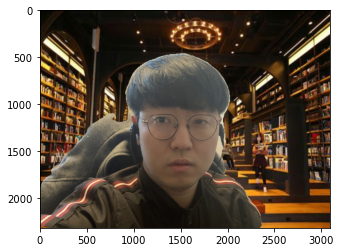

In [13]:
# 크로마키 버전

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인
img_orig = cv2.imread(img_path)
lib_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/library.jpg'  # 도서관 
img_lib = cv2.imread(lib_path) 
print (img_orig.shape)

#준비한 이미지를 네트워크에 넣기
#seg_map.max()는 넣은 사진에서 지정된 라벨들 중에서 가장 큰 값을 반환
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#고양이만 검출, 마스크를 만들고 시각화
#고양이을 뜻하는 15외에는 모두다 0으로 만듬
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#아까 전처리과정중에 사이즈를 작게 했기에 출력을 위해서 다시 복원
#복원시에는 보간을 사용해야 하는데, 정확하게 하기 위해서 cv2.INTER_LINEAR를 사용.
#결과물인 img_mask_up은 threshold(임계값)을 기준으로 이하면 0, 이상이면 255로 만든다.
#grayscale이어서 결과물이 까맣게 나온다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
img_lib = cv2.resize(img_lib, dsize=(3088,2316), interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#세그멘테이션 마스크를 이용해 배겸만 추출
#bitwise_not을 쓰면 배경은 255, 고양이은 0
#bitwise_and를 이용해 원래 이미지에 사람이 까만부분을 더한다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()


#배경만 나온 이미지를 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13)) #뒤에 숫자가 클수록 블러처리가 많이 됨
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#마스크가 255인 부분만 원본이미지, 나머지 부분은 블러한 값 가저오기
img_concat = np.where(img_mask_color==255, img_orig, img_lib)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 에러 이미지
<img src="images/error.jpg" align="left">

(2316, 3088, 3)
(2316, 3088, 3) (384, 513, 3) 16


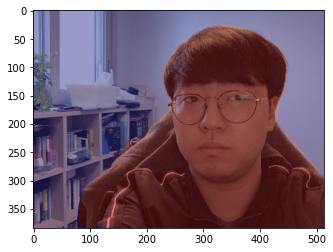

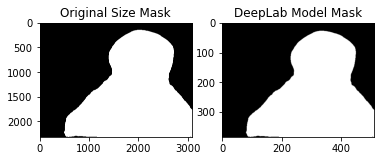

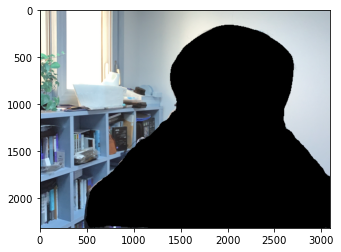

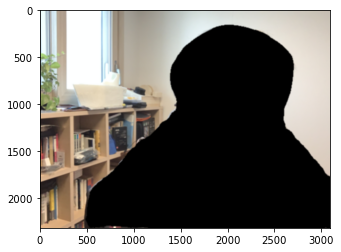

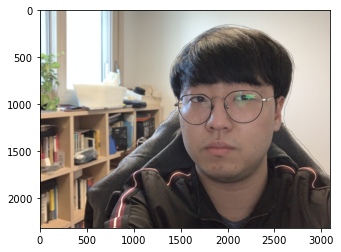

In [14]:
# 초점을 다르게 잡은 사진 버전

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

#준비한 이미지를 네트워크에 넣기
#seg_map.max()는 넣은 사진에서 지정된 라벨들 중에서 가장 큰 값을 반환
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#사람만 검출, 마스크를 만들고 시각화
#사람을 뜻하는 15외에는 모두다 0으로 만듬
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#아까 전처리과정중에 사이즈를 작게 했기에 출력을 위해서 다시 복원
#복원시에는 보간을 사용해야 하는데, 정확하게 하기 위해서 cv2.INTER_LINEAR를 사용.
#결과물인 img_mask_up은 threshold(임계값)을 기준으로 이하면 0, 이상이면 255로 만든다.
#grayscale이어서 결과물이 까맣게 나온다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#세그멘테이션 마스크를 이용해 배겸만 추출
#bitwise_not을 쓰면 배경은 255, 고양이은 0
#bitwise_and를 이용해 원래 이미지에 사람이 까만부분을 더한다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()


#배경만 나온 이미지를 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13)) #뒤에 숫자가 클수록 블러처리가 많이 됨
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#마스크가 255인 부분만 원본이미지, 나머지 부분은 블러한 값 가저오기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(2316, 3088, 3)
(2316, 3088, 3) (384, 513, 3) 16


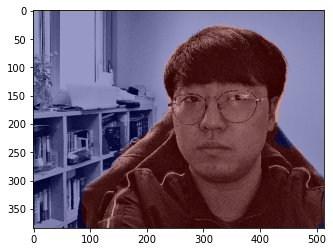

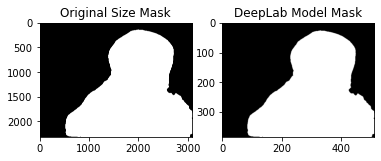

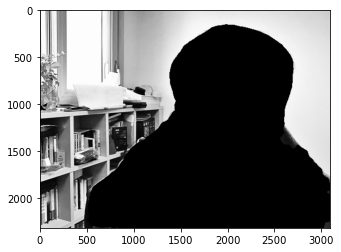

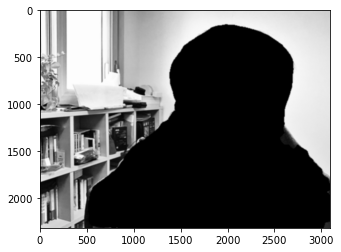

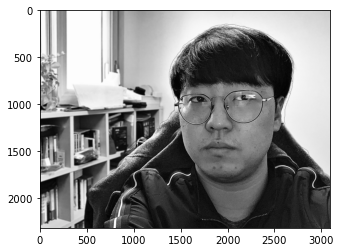

In [17]:
# 초점을 다르게 잡은 사진 버전

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

#준비한 이미지를 네트워크에 넣기
#seg_map.max()는 넣은 사진에서 지정된 라벨들 중에서 가장 큰 값을 반환
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#사람만 검출, 마스크를 만들고 시각화
#사람을 뜻하는 15외에는 모두다 0으로 만듬
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#아까 전처리과정중에 사이즈를 작게 했기에 출력을 위해서 다시 복원
#복원시에는 보간을 사용해야 하는데, 정확하게 하기 위해서 cv2.INTER_LINEAR를 사용.
#결과물인 img_mask_up은 threshold(임계값)을 기준으로 이하면 0, 이상이면 255로 만든다.
#grayscale이어서 결과물이 까맣게 나온다.
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#세그멘테이션 마스크를 이용해 배겸만 추출
#bitwise_not을 쓰면 배경은 255, 고양이은 0
#bitwise_and를 이용해 원래 이미지에 사람이 까만부분을 더한다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()


#배경만 나온 이미지를 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13)) #뒤에 숫자가 클수록 블러처리가 많이 됨
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#마스크가 255인 부분만 원본이미지, 나머지 부분은 블러한 값 가저오기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()